In [1]:
import os
import torch
from functools import partial
from torch import nn
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display
import numpy as np
import torch.nn.functional as F
from torch.distributions import Beta
from tqdm.auto import tqdm
import functools
from einops import rearrange, repeat
from scipy.linalg import sqrtm

from scipy.stats import gaussian_kde

from models.pfgmpp import EDMLoss
from models.mlp import CFGResNet
from likelihood import get_likelihood_fn
from models.embeddings import PositionalEmbedding

/home/ylzhuang/anaconda3/envs/sde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/tonyz/anaconda3/envs/pytorch2/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


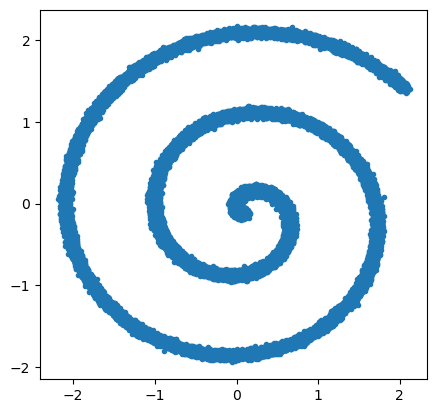

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def data_gen(length):
  t0=5
  k = 1.5
  strength = 0.03
  train_data = torch.zeros((length,2))
  train_param = torch.rand(length)*10-5
  train_data[:, 0]  = 0.2*k*(train_param[:]-t0)*torch.cos(k*(train_param[:]-t0))+strength*torch.randn(length)
  train_data[:, 1]  = 0.2*k*(train_param[:]-t0)*torch.sin(k*(train_param[:]-t0))+strength*torch.randn(length)
  return train_data, train_param

def get_pos_from_rad(rad, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  mu = torch.mean(tmp_arr, dim=0).unsqueeze(0)
  std = torch.std(tmp_arr, dim=0).unsqueeze(0)
  tmp_arr = (tmp_arr - mu) / std
  return tmp_arr.cpu().detach().numpy()

def get_pos_from_single_rad(rad, data_mu, data_std, k=1.5, t0=5):
  tmp_arr = torch.zeros([rad.shape[0],2])
  tmp_arr[:, 0]  = 0.2*k*(rad-t0)*torch.cos(k*(rad-t0))
  tmp_arr[:, 1]  = 0.2*k*(rad-t0)*torch.sin(k*(rad-t0))
  tmp_arr = (tmp_arr - data_mu) / data_std
  return tmp_arr.cpu().detach().numpy()

def swiss_roll_eval(xy_coord, rad, **kwargs):
  data_mu = kwargs.get('data_mu')
  data_std = kwargs.get('data_std')
  if data_mu is None or data_std is None:
    raise ValueError("Both data_mu and data_std must be provided")
  true_xy = get_pos_from_single_rad(rad, data_mu, data_std)
  return torch.tensor(true_xy, device=xy_coord.device) - xy_coord

# calculate frechet inception distance
def fid_metric(act1, act2):
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  if np.isnan(sigma1).any() or np.isnan(sigma2).any() or np.isinf(sigma1).any() or np.isinf(sigma2).any():
    print("Invalid values detected in sigma1 or sigma2. Returning NaN for metrics.")
    return (np.nan, np.nan)
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

def get_KLD(samp1=None, dat=None):
    # Load the data
    if samp1 is None and dat is None:
        samp1 = np.loadtxt('samples.out')
        dat = np.loadtxt('true_dat.out')

    # Parameters for the histogram
    bins = np.arange(-4, 4 + 0.16, 0.16)
    hist_range = [[-3, 3], [-3, 3]]
    histogram1, xedges, yedges = np.histogram2d(samp1[:, 0], samp1[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for samp1
    entropy_samp1 = -np.sum(histogram1 * np.log(histogram1 + 1.e-20)) * 0.16 * 0.16

    histogram2, _, _ = np.histogram2d(dat[:, 0], dat[:, 1], bins=[bins, bins], range=hist_range, density=True)
    # Calculate the entropy for true data
    entropy_dat = -np.sum(histogram2 * np.log(histogram2 + 1.e-20)) * 0.16 * 0.16

    # Flatten the histograms for KLD calculation
    flat_pdf_true = histogram2.flatten() + 1.e-20
    flat_pdf_gen = histogram1.flatten() + 1.e-20

    # Calculate the KLD
    KLD = np.sum(flat_pdf_true * np.log(flat_pdf_true / flat_pdf_gen)) * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
    print('KLD: ', KLD)
    #plot_distribution(xedges, yedges, histogram1, histogram2, hist_range)
    return KLD, entropy_samp1, entropy_dat

seed_everything(0)
data_type = 'swiss_roll' # 'circle'
#ndim = 2

train_data_length = int(1E5)

xlim_min = -1.5
xlim_max = 2.0
ylim_min = -1.5
ylim_max = 2.0

train_data, _ = data_gen(train_data_length)
data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
data_std = torch.std(train_data, dim=0).unsqueeze(0)
train_data = (train_data - data_mu) / data_std
#train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
generator = torch.Generator().manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)
#val_loader = torch.utils.data.DataLoader(
#    val_set, batch_size=batch_size, shuffle=True
#)

plt.plot(train_data[train_set.indices, 0], train_data[train_set.indices, 1], ".")
#plt.plot(train_data[val_set.indices, 0], train_data[val_set.indices, 1], ".")
#plt.xlim(xlim_min, xlim_max)
#plt.ylim(ylim_min, ylim_max)
plt.gca().set_aspect('equal', adjustable='box')

In [2]:
class Affine(nn.Module):
    #https://github.com/facebookresearch/deit/blob/263a3fcafc2bf17885a4af62e6030552f346dc71/resmlp_models.py#L16C9-L16C9
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        return self.alpha * x + self.beta    

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, time_emb_dim, dropout=0,
                 skip_scale=1, adaptive_scale=True, affine=False):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = time_emb_dim
        self.dropout = dropout
        self.skip_scale = skip_scale
        self.adaptive_scale = adaptive_scale

        self.linear1 = nn.Linear(in_dim, out_dim)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.res_linear = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        self.map_cond = nn.Linear(time_emb_dim, out_dim*(2 if adaptive_scale else 1))

        if affine:
            self.pre_norm = Affine(in_dim)
            self.post_norm = Affine(out_dim)
        else:
            self.pre_norm = nn.Identity()
            self.post_norm = nn.Identity()

    def forward(self, x, time_emb=None):
        #print(x.shape, emb.shape)
        orig = x
        params = nn.functional.silu(self.map_cond(time_emb).to(x.dtype))
        x = self.pre_norm(x)
        x = self.linear1(nn.functional.silu(x))
        if self.adaptive_scale:
            scale, shift = params.chunk(2, dim=-1)
            x = nn.functional.silu(torch.addcmul(shift, x, scale+1))
        else:
            x = nn.functional.silu(x.add_(params))

        x = self.linear2(nn.functional.dropout(x, p=self.dropout, training=self.training))
        x = self.post_norm(x)
        x = x.add_(self.res_linear(orig))
        x = x * self.skip_scale

        return x

class ResNet(torch.nn.Module):
    def __init__(self, in_dim, out_dim,
                model_dim      = 128,      # dim multiplier.
                dim_mult        = [1,1,1,1],# dim multiplier for each resblock layer.
                dim_mult_emb    = 4,
                num_blocks          = 4,        # Number of resblocks(mid) per level.
                dropout             = 0.,      # Dropout rate.
                emb_type            = "sinusoidal",# Timestep embedding type
                dim_mult_noise  = 1,        # Time embedding size
                adaptive_scale  = True,     # Feature-wise transformations, FiLM
                skip_scale      = 1.0,      # Skip connection scaling
                affine          = False    # Affine normalization for MLP
                ):

        super().__init__()

        emb_dim = model_dim * dim_mult_emb
        noise_dim = model_dim * dim_mult_noise
        block_kwargs = dict(dropout = dropout, skip_scale=skip_scale, adaptive_scale=adaptive_scale, affine=affine)

        self.map_noise = PositionalEmbedding(size=noise_dim, type=emb_type)
        self.map_layer = nn.Linear(noise_dim, emb_dim)
        #self.map_layer1 = nn.Linear(emb_dim, emb_dim)

        self.first_layer = nn.Linear(in_dim, model_dim)
        self.blocks = nn.ModuleList()
        cout = model_dim
        for level, mult in enumerate(dim_mult):
            for _ in range(num_blocks):
                cin = cout
                cout = model_dim * mult
                self.blocks.append(ResNetBlock(cin, cout, emb_dim, **block_kwargs))
        self.final_layer = nn.Linear(cout, out_dim)

    def forward(self, x, noise_labels):
        # Mapping
        emb = self.map_noise(noise_labels)
        #emb = emb.reshape(emb.shape[0], 2, -1).flip(1).reshape(*emb.shape) # why swap emb (sin/cos)?
        emb = nn.functional.silu(self.map_layer(emb))
        #emb = nn.functional.silu(self.map_layer1(emb))
        x = self.first_layer(x)
        for block in self.blocks:
            x = block(x, emb)
        x = self.final_layer(nn.functional.silu(x))
        return x

class EDM1DUncon(torch.nn.Module):
    def __init__(self,
        in_dim, out_dim,
        model_dim      = 128,      # dim multiplier.
        dim_mult        = [1,1,1,1],# dim multiplier for each resblock layer.
        dim_mult_emb    = 4,
        num_blocks          = 4,        # Number of resblocks(mid) per level.
        dropout             = 0.,      # Dropout rate.
        emb_type            = "sinusoidal",# Timestep embedding type
        dim_mult_noise  = 1,        # Time embedding size
        pfgmpp=False,
        D = 128,
        use_fp16        = False,            # Execute the underlying model at FP16 precision?
        sigma_min       = 0,                # Minimum supported noise level.
        sigma_max       = float('inf'),     # Maximum supported noise level.
        sigma_data      = 0.5,              # Expected standard deviation of the training data.
        model_type      = 'ResNet',   # Class name of the underlying model.
        **model_kwargs,                     # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.D = D
        self.N = in_dim
        self.label_dim = 0
        self.pfgmpp = pfgmpp
        self.use_fp16 = use_fp16
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data
        ###########
        self.model = globals()[model_type](self.in_dim, self.out_dim, model_dim=model_dim, dim_mult=dim_mult, dim_mult_emb=dim_mult_emb, num_blocks=num_blocks,
                                           dropout=dropout, emb_type=emb_type, dim_mult_noise=dim_mult_noise, **model_kwargs)

    def forward(self, x, sigma, class_labels=None, force_fp32=False,  **model_kwargs):

        x = x.to(torch.float32)

        sigma = sigma.to(torch.float32).reshape(-1, 1)
        class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim],
                                                                    device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        x_in = c_in * x
        F_x = self.model((x_in).to(dtype), c_noise.flatten(), **model_kwargs)

        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

class EDM1DCFG(torch.nn.Module):
    def __init__(self,
        in_dim, out_dim, cond_size,
        model_dim      = 128,      # dim multiplier.
        dim_mult        = [1,1,1,1],# dim multiplier for each resblock layer.
        dim_mult_emb    = 4,
        num_blocks          = 4,        # Number of resblocks(mid) per level.
        dropout             = 0.,      # Dropout rate.
        emb_type            = "sinusoidal",# Timestep embedding type
        dim_mult_time  = 1,        # Time embedding size
        pfgmpp=False,
        D = 128,
        use_fp16        = False,            # Execute the underlying model at FP16 precision?
        sigma_min       = 0,                # Minimum supported noise level.
        sigma_max       = float('inf'),     # Maximum supported noise level.
        sigma_data      = 0.5,              # Expected standard deviation of the training data.
        model_type      = 'CFGResNet',   # Class name of the underlying model.
        **model_kwargs,                     # Keyword arguments for the underlying model.
    ):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.D = D
        self.N = in_dim
        self.label_dim = cond_size
        self.pfgmpp = pfgmpp
        self.use_fp16 = use_fp16
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data
        ###########
        self.model = globals()[model_type](self.in_dim, self.out_dim, self.label_dim, model_dim=model_dim, dim_mult=dim_mult, dim_mult_emb=dim_mult_emb, num_blocks=num_blocks,
                                           dropout=dropout, emb_type=emb_type, dim_mult_time=dim_mult_time, **model_kwargs)

    def forward(self, x, sigma, class_labels=None, force_fp32=False,  **model_kwargs):

        x = x.to(torch.float32)

        sigma = sigma.to(torch.float32).reshape(-1, 1)
        class_labels = None if self.label_dim == 0 else torch.zeros([1, self.label_dim],
                                                                    device=x.device) if class_labels is None else class_labels.to(torch.float32).reshape(-1, self.label_dim)
        dtype = torch.float16 if (self.use_fp16 and not force_fp32 and x.device.type == 'cuda') else torch.float32

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        x_in = c_in * x
        F_x = self.model((x_in).to(dtype), class_labels, c_noise.flatten(), **model_kwargs)

        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

In [10]:
def edm_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=0,
    pfgmpp=False,
):

    N = net.N
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (
                sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])])  # t_N = 0

    if pfgmpp:
        x_next = latents.to(torch.float64)
    else:
        x_next = latents.to(torch.float64) * t_steps[0]

    whole_trajectory = torch.zeros((num_steps, *x_next.shape), dtype=torch.float64)
    # Main sampling loop.
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):  # 0, ..., N-1

        x_cur = x_next
        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)
        # Euler step.
        denoised = net(x_hat, repeat(t_hat.reshape(-1), 'w -> h w', h=x_hat.shape[0]), class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, repeat(t_next.reshape(-1), 'w -> h w', h=x_next.shape[0]), class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

        whole_trajectory[i] = x_next

    return x_next, whole_trajectory

def ablation_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=None, sigma_max=None, rho=7,
    solver='heun', discretization='edm', schedule='linear', scaling='none',
    epsilon_s=1e-3, C_1=0.001, C_2=0.008, M=1000, alpha=1,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    assert solver in ['euler', 'heun']
    assert discretization in ['vp', 've', 'iddpm', 'edm']
    assert schedule in ['vp', 've', 'linear']
    assert scaling in ['vp', 'none']

    # Helper functions for VP & VE noise level schedules.
    vp_sigma = lambda beta_d, beta_min: lambda t: (np.e ** (0.5 * beta_d * (t ** 2) + beta_min * t) - 1) ** 0.5
    vp_sigma_deriv = lambda beta_d, beta_min: lambda t: 0.5 * (beta_min + beta_d * t) * (sigma(t) + 1 / sigma(t))
    vp_sigma_inv = lambda beta_d, beta_min: lambda sigma: ((beta_min ** 2 + 2 * beta_d * (sigma ** 2 + 1).log()).sqrt() - beta_min) / beta_d
    ve_sigma = lambda t: t.sqrt()
    ve_sigma_deriv = lambda t: 0.5 / t.sqrt()
    ve_sigma_inv = lambda sigma: sigma ** 2

    # Select default noise level range based on the specified time step discretization.
    if sigma_min is None:
        vp_def = vp_sigma(beta_d=19.1, beta_min=0.1)(t=epsilon_s)
        sigma_min = {'vp': vp_def, 've': 0.02, 'iddpm': 0.002, 'edm': 0.002}[discretization]
    if sigma_max is None:
        vp_def = vp_sigma(beta_d=19.1, beta_min=0.1)(t=1)
        sigma_max = {'vp': vp_def, 've': 100, 'iddpm': 81, 'edm': 80}[discretization]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Compute corresponding betas for VP.
    vp_beta_d = 2 * (np.log(sigma_min ** 2 + 1) / epsilon_s - np.log(sigma_max ** 2 + 1)) / (epsilon_s - 1)
    vp_beta_min = np.log(sigma_max ** 2 + 1) - 0.5 * vp_beta_d

    # Define time steps in terms of noise level.
    step_indices = torch.arange(num_steps, dtype=torch.float64, devich.Size([32, 2, 64, 64]) torch.Size([32, 16])
tore=latents.device)
    if discretization == 'vp':
        orig_t_steps = 1 + step_indices / (num_steps - 1) * (epsilon_s - 1)
        sigma_steps = vp_sigma(vp_beta_d, vp_beta_min)(orig_t_steps)
    elif discretization == 've':
        orig_t_steps = (sigma_max ** 2) * ((sigma_min ** 2 / sigma_max ** 2) ** (step_indices / (num_steps - 1)))
        sigma_steps = ve_sigma(orig_t_steps)
    elif discretization == 'iddpm':
        u = torch.zeros(M + 1, dtype=torch.float64, device=latents.device)
        alpha_bar = lambda j: (0.5 * np.pi * j / M / (C_2 + 1)).sin() ** 2
        for j in torch.arange(M, 0, -1, device=latents.device): # M, ..., 1
            u[j - 1] = ((u[j] ** 2 + 1) / (alpha_bar(j - 1) / alpha_bar(j)).clip(min=C_1) - 1).sqrt()
        u_filtered = u[torch.logical_and(u >= sigma_min, u <= sigma_max)]
        sigma_steps = u_filtered[((len(u_filtered) - 1) / (num_steps - 1) * step_indices).round().to(torch.int64)]
    else:
        assert discretization == 'edm'
        sigma_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

    # Define noise level schedule.
    if schedule == 'vp':
        sigma = vp_sigma(vp_beta_d, vp_beta_min)
        sigma_deriv = vp_sigma_deriv(vp_beta_d, vp_beta_min)
        sigma_inv = vp_sigma_inv(vp_beta_d, vp_beta_min)
    elif schedule == 've':
        sigma = ve_sigma
        sigma_deriv = ve_sigma_deriv
        sigma_inv = ve_sigma_inv
    else:
        assert schedule == 'linear'
        sigma = lambda t: t
        sigma_deriv = lambda t: 1
        sigma_inv = lambda sigma: sigma

    # Define scaling schedule.
    if scaling == 'vp':
        s = lambda t: 1 / (1 + sigma(t) ** 2).sqrt()
        s_deriv = lambda t: -sigma(t) * sigma_deriv(t) * (s(t) ** 3)
    else:
        assert scaling == 'none'
        s = lambda t: 1
        s_deriv = lambda t: 0

    # Compute final time steps based on the corresponding noise levels.
    t_steps = sigma_inv(net.round_sigma(sigma_steps))
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    t_next = t_steps[0]
    x_next = latents.to(torch.float64) * (sigma(t_next) * s(t_next))
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= sigma(t_cur) <= S_max else 0
        t_hat = sigma_inv(net.round_sigma(sigma(t_cur) + gamma * sigma(t_cur)))
        x_hat = s(t_hat) / s(t_cur) * x_cur + (sigma(t_hat) ** 2 - sigma(t_cur) ** 2).clip(min=0).sqrt() * s(t_hat) * S_noise * randn_like(x_cur)

        # Euler step.
        h = t_next - t_hat
        denoised = net(x_hat / s(t_hat), sigma(t_hat), class_labels).to(torch.float64)
        d_cur = (sigma_deriv(t_hat) / sigma(t_hat) + s_deriv(t_hat) / s(t_hat)) * x_hat - sigma_deriv(t_hat) * s(t_hat) / sigma(t_hat) * denoised
        x_prime = x_hat + alpha * h * d_cur
        t_prime = t_hat + alpha * h

        # Apply 2nd order correction.
        if solver == 'euler' or i == num_steps - 1:
            x_next = x_hat + h * d_cur
        else:
            assert solver == 'heun'
            denoised = net(x_prime / s(t_prime), sigma(t_prime), class_labels).to(torch.float64)
            d_prime = (sigma_deriv(t_prime) / sigma(t_prime) + s_deriv(t_prime) / s(t_prime)) * x_prime - sigma_deriv(t_prime) * s(t_prime) / sigma(t_prime) * denoised
            x_next = x_hat + h * ((1 - 1 / (2 * alpha)) * d_cur + 1 / (2 * alpha) * d_prime)

    return x_next

class StackedRandomGenerator:
    def __init__(self, device, seeds):
        super().__init__()
        self.generators = [torch.Generator(device).manual_seed(int(seed) % (1 << 32)) for seed in seeds]
        self.seeds = seeds
        self.device = device

    def randn(self, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randn(size[1:], generator=gen, **kwargs) for gen in self.generators])

    def rand_beta_prime(self, size, N=3072, D=128, **kwargs):
        # sample from beta_prime (N/2, D/2)
        # print(f"N:{N}, D:{D}")
        assert size[0] == len(self.seeds)
        latent_list = []
        beta_gen = Beta(torch.FloatTensor([N / 2.]), torch.FloatTensor([D / 2.]))
        for seed in self.seeds:
            torch.manual_seed(seed)
            sample_norm = beta_gen.sample().to(kwargs['device']).double()
            # inverse beta distribution
            inverse_beta = sample_norm / (1-sample_norm)

            if N < 256 * 256 * 3:
                sigma_max = 80
            else:
                sigma_max = kwargs['sigma_max']

            sample_norm = torch.sqrt(inverse_beta) * sigma_max * np.sqrt(D)
            gaussian = torch.randn(N).to(sample_norm.device)
            unit_gaussian = gaussian / torch.norm(gaussian, p=2)
            init_sample = unit_gaussian * sample_norm
            latent_list.append(init_sample.reshape((1, *size[1:])))

        latent = torch.cat(latent_list, dim=0)
        return latent

    def randn_like(self, input):
        return self.randn(input.shape, dtype=input.dtype, layout=input.layout, device=input.device)

    def randint(self, *args, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randint(*args, size=size[1:], generator=gen, **kwargs) for gen in self.generators])

In EDM loss: D:64, N:2
Model weights loaded successfully, computing last epoch loss.
start sampling ...
KLD:  0.0121247195024145
Train data size: 100000


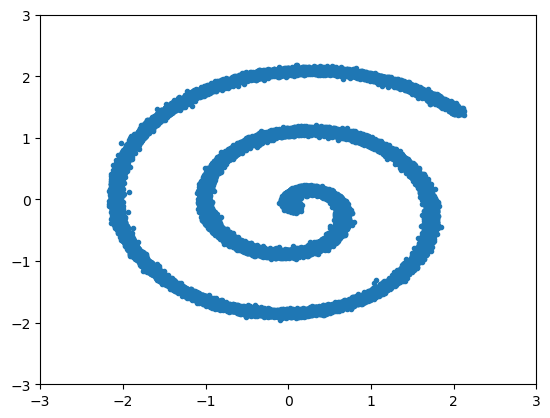

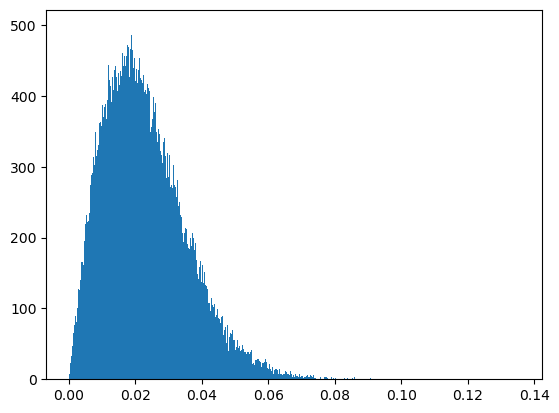

0.02302736953971996


In [12]:
seed_everything(0)
# optimization
learning_rate = 5e-5
num_epochs = 500


device='cuda'
#D_values = np.array([128, 256, 512, 1024, 2048, 4096, 8192])
D_values = np.array([64])
sample_size = int(1E6)
orig_sample, orig_labels = data_gen(sample_size)
data_mu = torch.mean(orig_sample, dim=0).unsqueeze(0)
data_std = torch.std(orig_sample, dim=0).unsqueeze(0)
orig_sample = (orig_sample - data_mu) / data_std
last_loss_values = []
fid_values = []
avg_nll_values = []
KLD_arr = []
H_gen_arr = []
H_true_arr = []


pfgmpp = True
Training =False
output_step = 10

for D in D_values:
    seed_everything(0)
    train_data, train_labels = data_gen(train_data_length)
    data_mu = torch.mean(train_data, dim=0).unsqueeze(0)
    data_std = torch.std(train_data, dim=0).unsqueeze(0)
    train_data = (train_data - data_mu) / data_std
    #train_data = 2*(train_data-torch.min(train_data, dim=0)[0])/(torch.max(train_data,dim=0)[0]-torch.min(train_data, dim=0)[0])-1
    train_set = [
        (train_data[i], train_labels[i]) for i in range(train_data_length)
    ]
    generator = torch.Generator().manual_seed(0)
    train_set, val_set = torch.utils.data.random_split(train_set, [1,0], generator=generator)

    batch_size = 256
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size
    )
    '''
    model = EDM1DUncon(2, 2, model_dim=128,
                    dim_mult=[1,1,1], dim_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", dim_mult_noise=1, affine=True,
                    D=D, pfgmpp=pfgmpp)
    '''
    model = EDM1DCFG(2, 2, 1, model_dim=128,
                    dim_mult=[1,1,1], dim_mult_emb=1, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", dim_mult_time=1, affine=True,
                    D=D, pfgmpp=pfgmpp)
    loss_fn = EDMLoss(D=D, N=model.N)
    file_path = f'mdl_weights/pfgm_D_{D}.pth'

    if os.path.exists(file_path) and not Training:
        model.load_state_dict(torch.load(file_path))
        print("Model weights loaded successfully, computing last epoch loss.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )
        for epoch in range(1):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                loss = loss_fn(model, x, labels=c, augment_pipe=None, stf=False, pfgmpp=model.pfgmpp)
                
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                num_items += x.shape[0]
                avg_loss += loss.mean().item() * x.shape[0]
    else:
        print("No saved model weights found or Training=True.")
        model.train()
        model.to(device)

        optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate,
            )

        global_step = 0
        frames = []
        loss_v = []
        loss_avg = []
        #val_loss_avg = []

        #tqdm_epoch = tqdm.notebook.trange(num_epochs)
        best_val_loss = float('inf')
        print('training ...')
        for epoch in range(num_epochs):
            model.train()
            avg_loss = 0.
            num_items = 0

            for step, batch in enumerate(train_loader):
                x = batch[0]
                c = batch[1]
                x = x.to(device)
                c = c.to(device)
                batch_size = x.shape[0]
                loss = loss_fn(model, x, labels=c, augment_pipe=None, stf=False, pfgmpp=model.pfgmpp)
                
                optimizer.zero_grad()
                loss.sum().mul(1/batch_size).backward()
                optimizer.step()
                avg_loss += loss.mean().item() * batch_size
                num_items += x.shape[0]
                loss_v.append(loss.mean().item() * batch_size)
                loss_avg.append(avg_loss / num_items)
            # Print the averaged training loss so far.
            if epoch % output_step == 0 or epoch == num_epochs - 1:
                print(f"Epoch {epoch} | Loss: {avg_loss / num_items:.4f}")
        torch.save(model.state_dict(), file_path)
        print('train data length: ', train_data_length, ' last_loss: ', avg_loss / num_items)

    print('start sampling ...')
    sample_size = 100000
    model.eval()
    last_loss = avg_loss / num_items
    test_cond = torch.rand(sample_size, device=device)*10-5
    rnd = StackedRandomGenerator(device, range(sample_size))
    if pfgmpp:
        latents = rnd.rand_beta_prime([sample_size, model.in_dim],
                            N=model.N,
                            D=D,
                            pfgmpp=pfgmpp,
                            device=device,
                            #sigma_max=sampler_kwargs['sigma_max'] if (N > 256 * 256 * 3) else 80)
                            sigma_max=80)
    else:
        latents = rnd.randn([sample_size, model.in_dim],
                            device=device)
    with torch.no_grad():
        samples, _ = edm_sampler(model, latents=latents, class_labels=test_cond, randn_like=rnd.randn_like, pfgmpp=pfgmpp)
        #samples = ablation_sampler(model, latents=latents, class_labels=test_cond, randn_like=rnd.randn_like)
    #samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
    samples = samples.detach().cpu().numpy()
    fid = fid_metric(samples, orig_sample.detach().cpu().numpy())
    inverse_scaler = 1 # dummy param
    #likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
    #nll = likelihood_fn(model, orig_sample.to(device))[0]
    #avg_nll = np.mean(nll.detach().cpu().numpy())
    '''
    nll_total = 0
    process_batch_size = 100000
    for i in range(0, orig_sample.size(0), process_batch_size):
        batch = orig_sample[i:i + process_batch_size].to(device)  
        batch_nll = likelihood_fn(model, batch)[0]  
        nll_total += batch_nll.sum().item()  
    # Calculate the average NLL
    avg_nll = nll_total / orz?Qu?ggf.cvM$Z5ig_sample.size(0)
    '''

    last_loss_values.append(last_loss)
    fid_values.append(fid)
    #avg_nll_values.append(avg_nll)
    kld, H_gen, H_true = get_KLD(samp1=samples, dat=orig_sample.detach().cpu().numpy())
    KLD_arr.append(kld)
    H_gen_arr.append(H_gen)
    H_true_arr.append(H_true)

    print('Train data size:', train_data_length)
    plt.plot(samples[:,0], samples[:,1], ".")
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.show()
    true_pos = get_pos_from_rad(test_cond)
    avg_err = np.mean(np.abs(samples-true_pos), axis=1)
    plt.hist(avg_err, bins=1000)
    plt.show()
    print(np.mean(avg_err))

In [4]:
D=128
seed_everything(0)

model = ResNet(2, 2, label_dim=0, augment_dim=0, model_channels=128,
                channel_mult=[1,1,1], channel_mult_emb=1, num_blocks=2,
                dropout=0, emb_type="sinusoidal", channel_mult_noise=1)
model.train()
model.to(device)

PFGMPP_loss_fn = EDMLoss(D=D, N=2, gamma=5) #gamma dummy var for now
model.load_state_dict(torch.load('mdl_weights/D_128.pth'))


In EDM loss: D:128, N:2


<All keys matched successfully>

In [4]:
import pandas as pd

results_df = pd.DataFrame({
    'D': np.repeat(D_values, len(D_values)),
    'last_loss': last_loss_values,
    'fid': fid_values,
    #'avg_nll': avg_nll_values
})

print(results_df)

     D  last_loss       fid
0  128  132.23554  0.064125


In [18]:
#results_df.to_csv("results.csv", index=False)
results_df = pd.read_csv("results.csv")

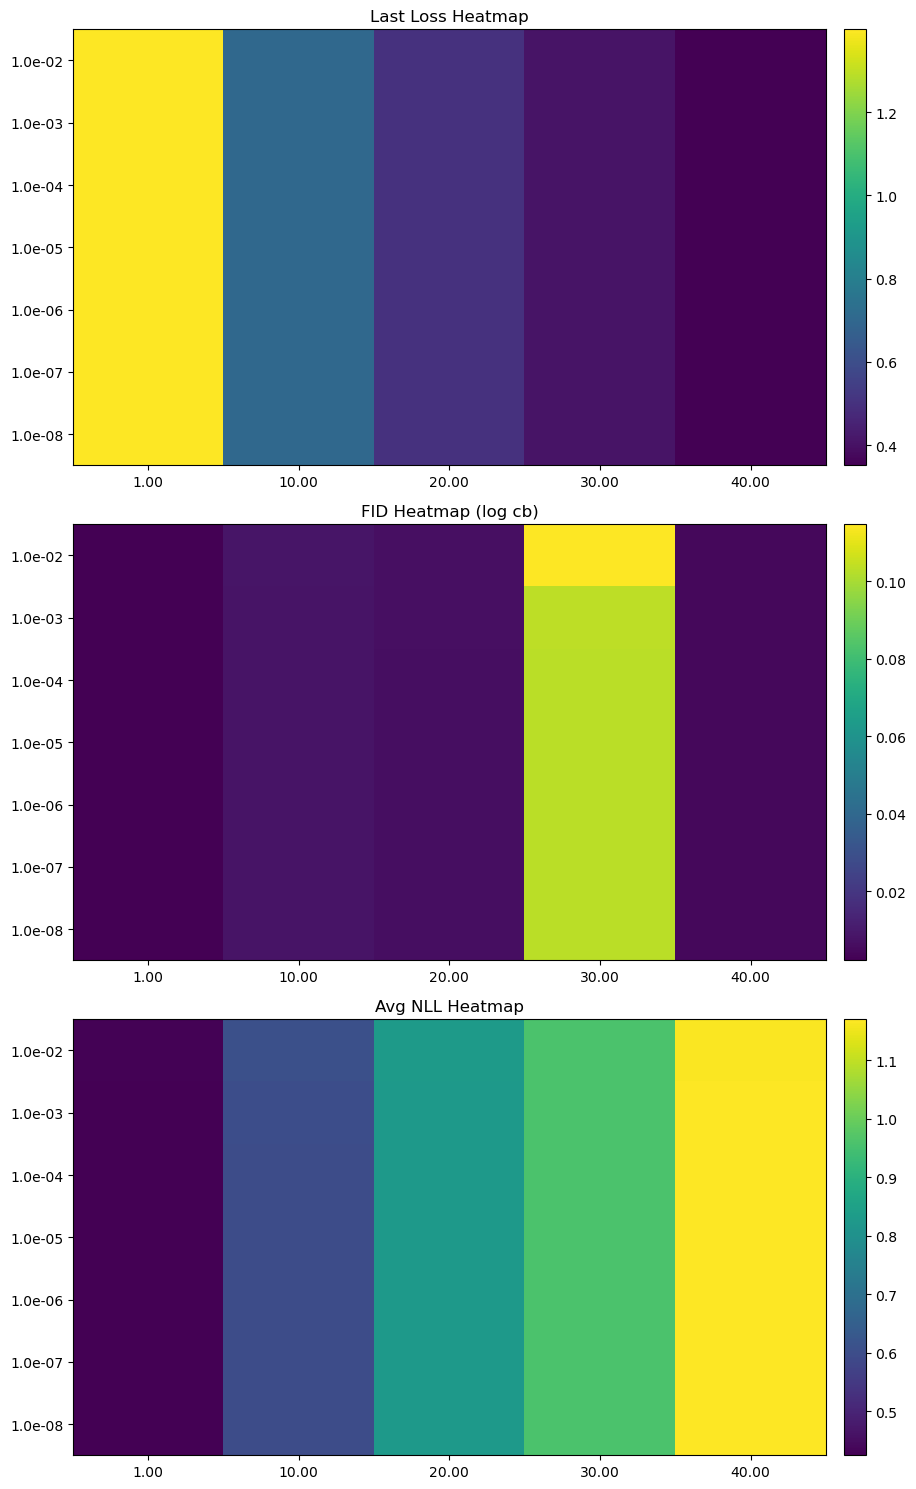

In [32]:
import matplotlib.pyplot as plt

# Dummy DataFrame for demonstration purposes
import numpy as np
import pandas as pd

# Reshape columns to matrix form for heatmap
last_loss_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='last_loss').values
fid_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='fid').values
avg_nll_matrix = results_df.pivot(index='beta_min', columns='beta_max', values='avg_nll').values
log_fid_matrix = np.log1p(fid_matrix)

# Plotting heatmaps
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Last Loss heatmap
cax1 = ax[0].imshow(last_loss_matrix[:,:5], aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title('Last Loss Heatmap')
ax[0].set_xticks(np.arange(len(beta_max_values)))
ax[0].set_yticks(np.arange(len(beta_min_values)))
ax[0].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[0].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax1, ax=ax[0], orientation='vertical', pad=0.02)

# FID heatmap
cax2 = ax[1].imshow(log_fid_matrix[:,:5], aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title('FID Heatmap (log cb)')
ax[1].set_xticks(np.arange(len(beta_max_values)))
ax[1].set_yticks(np.arange(len(beta_min_values)))
ax[1].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[1].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax2, ax=ax[1], orientation='vertical', pad=0.02)

# Avg NLL heatmap
cax3 = ax[2].imshow(avg_nll_matrix[:,:5], aspect='auto', origin='lower', cmap='viridis')
ax[2].set_title('Avg NLL Heatmap')
ax[2].set_xticks(np.arange(len(beta_max_values)))
ax[2].set_yticks(np.arange(len(beta_min_values)))
ax[2].set_xticklabels([f"{val:.2f}" for val in beta_max_values])
ax[2].set_yticklabels([f"{val:.1e}" for val in beta_min_values])
fig.colorbar(cax3, ax=ax[2], orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()


In [10]:
last_loss_matrix

array([[0.9065555 , 0.77404733, 0.33314515, 0.08110139, 0.40724117,
        0.23223414, 0.13248763, 0.05342718, 0.72559436, 0.01142746],
       [0.77058075, 0.14694665, 0.07952208, 0.08960303, 0.67204781,
        0.24536721, 0.42053947, 0.55736879, 0.86055117, 0.72704426],
       [0.27032791, 0.1314828 , 0.05537432, 0.30159863, 0.26211815,
        0.45614057, 0.68328134, 0.69562545, 0.28351885, 0.37992696],
       [0.18115096, 0.78854551, 0.05684808, 0.69699724, 0.7786954 ,
        0.77740756, 0.25942256, 0.37381314, 0.58759964, 0.2728219 ],
       [0.3708528 , 0.19705428, 0.45985588, 0.0446123 , 0.79979588,
        0.07695645, 0.51883515, 0.3068101 , 0.57754295, 0.95943334],
       [0.64557024, 0.03536244, 0.43040244, 0.51001685, 0.53617749,
        0.68139251, 0.2775961 , 0.12886057, 0.39267568, 0.95640572],
       [0.18713089, 0.90398395, 0.54380595, 0.45691142, 0.88204141,
        0.45860396, 0.72416764, 0.39902532, 0.90404439, 0.69002502],
       [0.69962205, 0.3277204 , 0.7567786

In [9]:
np.hstack((np.array([1]),np.linspace(10, 100, num=10)))

array([  1.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [6]:
hidden_size = 128
hidden_layers = 6
embedding_size = 128
time_embedding = 'sinusoidal'
input_embedding = 'sinusoidal'
cond_embedding = 'sinusoidal'
device='cuda'
model = MLP_SS(
        hidden_size=hidden_size,
        hidden_layers=hidden_layers,
        emb_size=embedding_size,
        time_emb=time_embedding,
        input_emb=input_embedding).to(device)
model.load_state_dict(torch.load('mdl_weights/0.0001_0.5.pth'))

beta_min = 1e-4
beta_max = 0.5
vp = uncon_VP_1D(beta_min, beta_max)

In [12]:
latent = torch.randn(train_data_length, 2, device=device)
samples = edm_sampler(model, latent, None, 100, pfgmpp=True)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()

In [10]:
vp = uncon_VP_1D(beta_min, beta_max)
vp_sampler = uncon_EulerMaruyama(1000, 1e-5, train_data_length)
vp_ode_sampler = ODE_uncon_EulerMaruyama(1000, 1e-5, 10000, 1e-5, 1e-5)
samples, _ = vp_sampler(model, vp, train_data.shape, device)
#samples, _ = vp_ode_sampler(model, vp, train_data.shape, device)
samples = samples.detach().cpu().numpy()

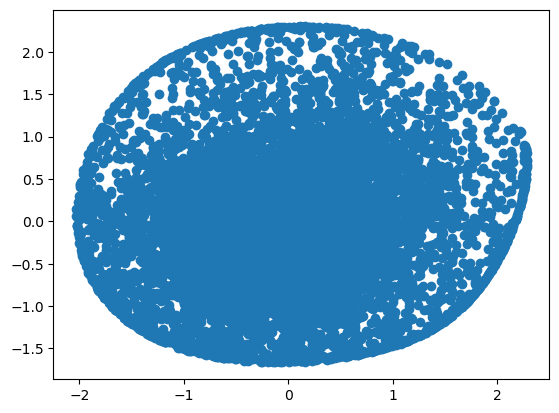

In [13]:
plt.scatter(samples[:,0], samples[:,1])
#plt.xlim((-5,5))
#plt.ylim((-5,5))

In [17]:
fid_metric(samples, train_data.detach().cpu().numpy())

1.557473002914324e+17

In [8]:
inverse_scaler = 1 # dummy param
likelihood_fn = get_likelihood_fn(vp, inverse_scaler)
bpd = likelihood_fn(model, train_data.to(device))[0]

tensor([ 1.3225, -0.6731,  1.8295,  ...,  1.5394,  2.7051,  1.6966],
       device='cuda:0')


In [13]:
np.mean(bpd.detach().cpu().numpy())

1.6767131

### Test EDM loss with Euler sampelr

In [2]:
from models.unets import PFGMPPUNet
from dataloaders.loaders import DarcyLoader
from models.pfgmpp import StackedRandomGenerator, edm_sampler

unet_params = {
    "dim": 64,
    "in_channels": 2,
    "out_channels": 2,
    "cond_size": 16,
    "kernel_size": 3,
    "padding": 1,
    "model_channels": 256,
    "channel_mult": [1, 2],
    "channel_mult_emb": 2,
    "num_blocks": 1,
    "dropout": 0.0,
    "dim_mult_time": 1,
    "cond_drop_prob": 0.0,
    "adaptive_scale": True,
    "skip_scale": 1,
    "groups": 8,
    "pfgmpp": False,
    "D": 2048,
    "use_fp16": False,
    "sigma_min": 0,
    "sigma_max": 1e10,
    "sigma_data": 0.5,
    "model_type": 'CFGUNet'
}

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    # Get the number of GPUs available
    n_gpu = torch.cuda.device_count()
    print(f"Number of GPUs available: {n_gpu}")
    # Select a specific GPU
    #device = torch.device('cuda:0')  # Selects the first GPU
    device = 'cpu'
    print(f"Selected GPU: {device}")
else:
    print("CUDA is not available.")

model = PFGMPPUNet(**unet_params)
# Load the checkpoint
ckpt_path = 'test_log/cfg_edm/2023-12-29T11-27-36_cfgedm/checkpoints/last.ckpt'
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)

    # Adjust the keys in the state dictionary
    state_dict = checkpoint['state_dict']
    new_state_dict = {key.replace('unet.', ''): value for key, value in state_dict.items()}

    # Load the adjusted state dictionary
    model.load_state_dict(new_state_dict)
else:
    print(f"Checkpoint not found at {ckpt_path}")
model = model.to(device)

tmp_dataloader = DarcyLoader(data_dir='/home/csjacobs/git/diffusionPDE/datasets/Darcy_n16', batch_size=32,
                             num_workers=1)
tmp_dataloader.setup('1')


CUDA is available.
Number of GPUs available: 4
Selected GPU: cpu


In [13]:
def ablation_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=None, sigma_max=None, rho=7,
    solver='heun', discretization='edm', schedule='linear', scaling='none',
    deterministic=False, epsilon_s=1e-3, C_1=0.001, C_2=0.008, M=1000, alpha=1,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    assert solver in ['euler', 'heun']
    assert discretization in ['vp', 've', 'iddpm', 'edm']
    assert schedule in ['vp', 've', 'linear']
    assert scaling in ['vp', 'none']
    assert deterministic in [True, False]

    # Helper functions for VP & VE noise level schedules.
    vp_sigma = lambda beta_d, beta_min: lambda t: (np.e ** (0.5 * beta_d * (t ** 2) + beta_min * t) - 1) ** 0.5
    vp_sigma_deriv = lambda beta_d, beta_min: lambda t: 0.5 * (beta_min + beta_d * t) * (sigma(t) + 1 / sigma(t))
    vp_sigma_inv = lambda beta_d, beta_min: lambda sigma: ((beta_min ** 2 + 2 * beta_d * (sigma ** 2 + 1).log()).sqrt() - beta_min) / beta_d
    ve_sigma = lambda t: t.sqrt()
    ve_sigma_deriv = lambda t: 0.5 / t.sqrt()
    ve_sigma_inv = lambda sigma: sigma ** 2

    # Select default noise level range based on the specified time step discretization.
    if sigma_min is None:
        vp_def = vp_sigma(beta_d=19.9, beta_min=0.1)(t=epsilon_s)
        sigma_min = {'vp': vp_def, 've': 0.02, 'iddpm': 0.002, 'edm': 0.002}[discretization]
    if sigma_max is None:
        vp_def = vp_sigma(beta_d=19.9, beta_min=0.1)(t=1)
        sigma_max = {'vp': vp_def, 've': 100, 'iddpm': 81, 'edm': 80}[discretization]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Compute corresponding betas for VP.
    vp_beta_d = 2 * (np.log(sigma_min ** 2 + 1) / epsilon_s - np.log(sigma_max ** 2 + 1)) / (epsilon_s - 1)
    vp_beta_min = np.log(sigma_max ** 2 + 1) - 0.5 * vp_beta_d

    # Define time steps in terms of noise level.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    if discretization == 'vp':
        orig_t_steps = 1 + step_indices / (num_steps - 1) * (epsilon_s - 1)
        sigma_steps = vp_sigma(vp_beta_d, vp_beta_min)(orig_t_steps)
    elif discretization == 've':
        orig_t_steps = (sigma_max ** 2) * ((sigma_min ** 2 / sigma_max ** 2) ** (step_indices / (num_steps - 1)))
        sigma_steps = ve_sigma(orig_t_steps)
    elif discretization == 'iddpm':
        u = torch.zeros(M + 1, dtype=torch.float64, device=latents.device)
        alpha_bar = lambda j: (0.5 * np.pi * j / M / (C_2 + 1)).sin() ** 2
        for j in torch.arange(M, 0, -1, device=latents.device): # M, ..., 1
            u[j - 1] = ((u[j] ** 2 + 1) / (alpha_bar(j - 1) / alpha_bar(j)).clip(min=C_1) - 1).sqrt()
        u_filtered = u[torch.logical_and(u >= sigma_min, u <= sigma_max)]
        sigma_steps = u_filtered[((len(u_filtered) - 1) / (num_steps - 1) * step_indices).round().to(torch.int64)]
    else:
        assert discretization == 'edm'
        sigma_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

    # Define noise level schedule.
    if schedule == 'vp':
        sigma = vp_sigma(vp_beta_d, vp_beta_min)
        sigma_deriv = vp_sigma_deriv(vp_beta_d, vp_beta_min)
        sigma_inv = vp_sigma_inv(vp_beta_d, vp_beta_min)
    elif schedule == 've':
        sigma = ve_sigma
        sigma_deriv = ve_sigma_deriv
        sigma_inv = ve_sigma_inv
    else:
        assert schedule == 'linear'
        sigma = lambda t: t
        sigma_deriv = lambda t: 1
        sigma_inv = lambda sigma: sigma

    # Define scaling schedule.
    if scaling == 'vp':
        s = lambda t: 1 / (1 + sigma(t) ** 2).sqrt()
        s_deriv = lambda t: -sigma(t) * sigma_deriv(t) * (s(t) ** 3)
    else:
        assert scaling == 'none'
        s = lambda t: 1
        s_deriv = lambda t: 0

    # Compute final time steps based on the corresponding noise levels.
    t_steps = sigma_inv(net.round_sigma(sigma_steps))
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    t_next = t_steps[0]
    x_next = latents.to(torch.float64) * (sigma(t_next) * s(t_next))
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        if not deterministic:
            # Increase noise temporarily.
            gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= sigma(t_cur) <= S_max else 0
            t_hat = sigma_inv(net.round_sigma(sigma(t_cur) + gamma * sigma(t_cur)))
            x_hat = s(t_hat) / s(t_cur) * x_cur + (sigma(t_hat) ** 2 - sigma(t_cur) ** 2).clip(min=0).sqrt() * s(t_hat) * S_noise * randn_like(x_cur)
        else:
            t_hat = t_cur
            x_hat = x_cur

        # Euler step.
        h = t_next - t_hat
        #print(sigma(t_hat).reshape(-1).shape)
        denoised = net(x_hat / s(t_hat), repeat(sigma(t_hat).reshape(-1), 'w -> h w', h=x_hat.shape[0]), class_labels).to(torch.float64)
        # For edm, d_cur = (1/t_hat)*x_hat - (1/t_hat)*denoised) 
        d_cur = (sigma_deriv(t_hat) / sigma(t_hat) + s_deriv(t_hat) / s(t_hat)) * x_hat - sigma_deriv(t_hat) * s(t_hat) / sigma(t_hat) * denoised
        x_prime = x_hat + alpha * h * d_cur
        t_prime = t_hat + alpha * h

        # Apply 2nd order correction.
        if solver == 'euler' or i == num_steps - 1:
            x_next = x_hat + h * d_cur
        else:
            assert solver == 'heun'
            denoised = net(x_prime / s(t_prime), repeat(sigma(t_hat).reshape(-1), 'w -> h w', h=x_hat.shape[0]), class_labels).to(torch.float64)
            d_prime = (sigma_deriv(t_prime) / sigma(t_prime) + s_deriv(t_prime) / s(t_prime)) * x_prime - sigma_deriv(t_prime) * s(t_prime) / sigma(t_prime) * denoised
            x_next = x_hat + h * ((1 - 1 / (2 * alpha)) * d_cur + 1 / (2 * alpha) * d_prime)

    return x_next

In [14]:
x, c = next(iter(tmp_dataloader.train_dataloader()))
x = x.to(device)
c = c.to(device)
print(x.shape, c.shape)

torch.Size([32, 2, 64, 64]) torch.Size([32, 16])


In [24]:
with torch.no_grad():
    model.eval()
    rnd = StackedRandomGenerator(device, range(x.shape[0]))
    latents = rnd.randn(x.shape, device=device)
    # deterministic = True for PF ODE?
    samples = ablation_sampler(model, latents=latents, num_steps=18, class_labels=c, randn_like=rnd.randn_like,
                               discretization='edm', solver='euler', deterministic=True)

In [26]:
mean_deviation = []
for num_steps in [2, 4, 8, 16, 32]:
    with torch.no_grad():
        model.eval()
        rnd = StackedRandomGenerator(device, range(x.shape[0]))
        latents = rnd.randn(x.shape, device=device)
        # deterministic = True for PF ODE?
        samples = ablation_sampler(model, latents=latents, num_steps=num_steps, class_labels=c, randn_like=rnd.randn_like,
                                discretization='edm', solver='euler', deterministic=True)
    mean_deviation.append(torch.mean(torch.sum(torch.abs(samples-x), dim=(1,2,3))))

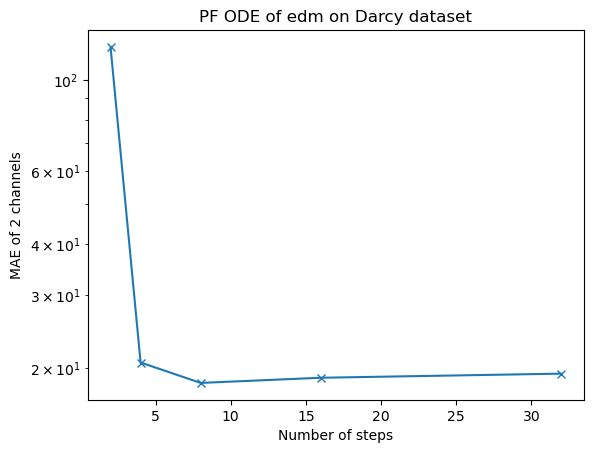

In [29]:
plt.plot([2, 4, 8, 16, 32], mean_deviation, marker='x')
plt.xlabel('Number of steps')
plt.ylabel('MAE of 2 channels')
# y log scale
plt.yscale('log')
plt.title('PF ODE of edm on Darcy dataset')
plt.show()

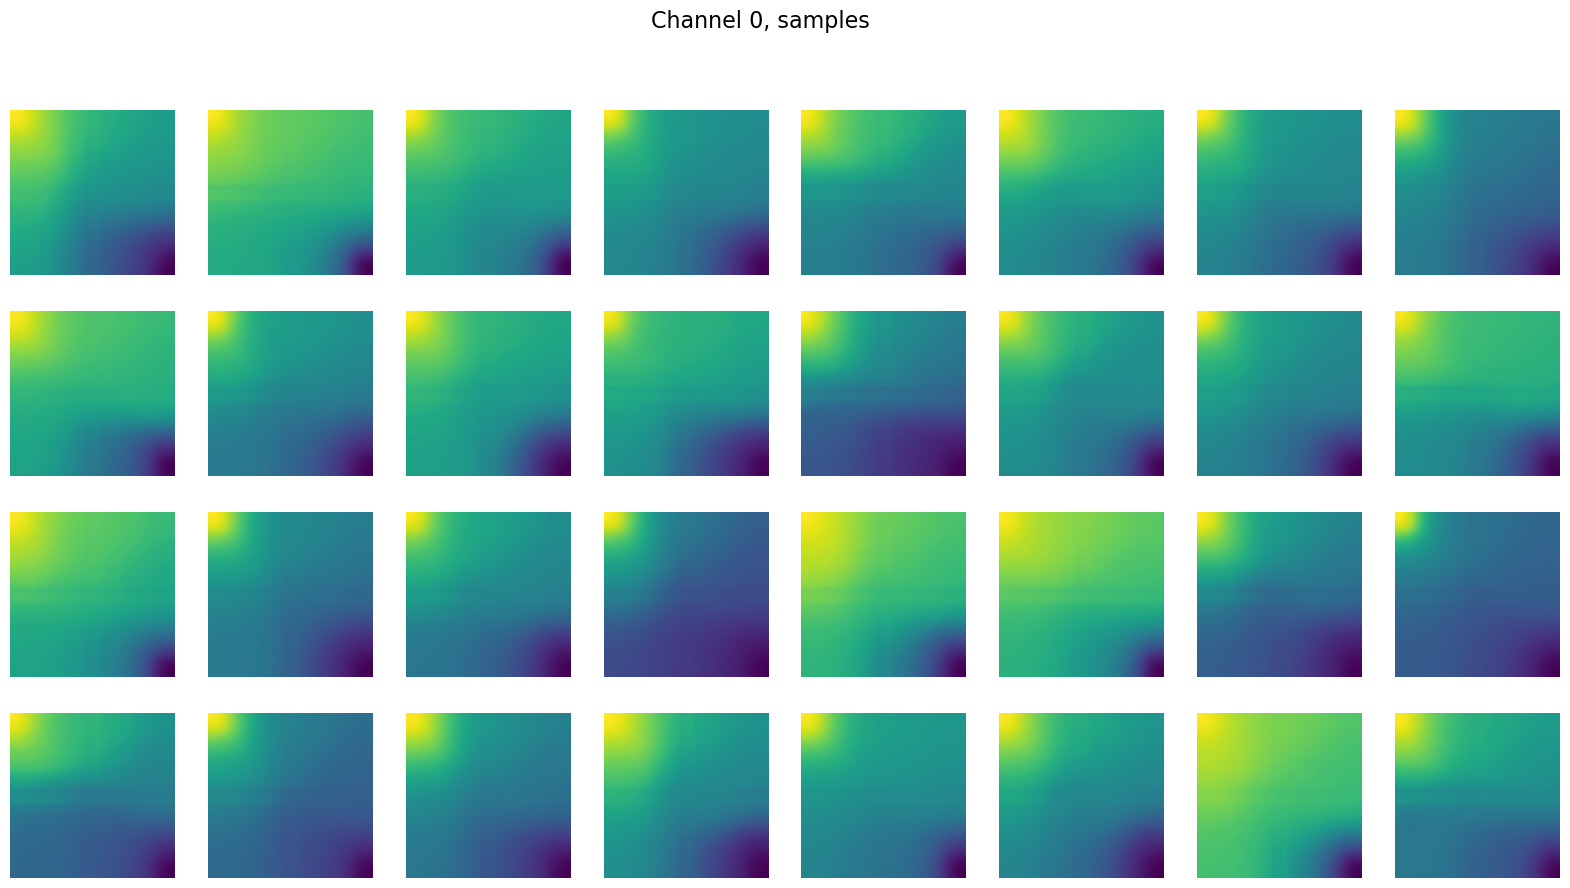

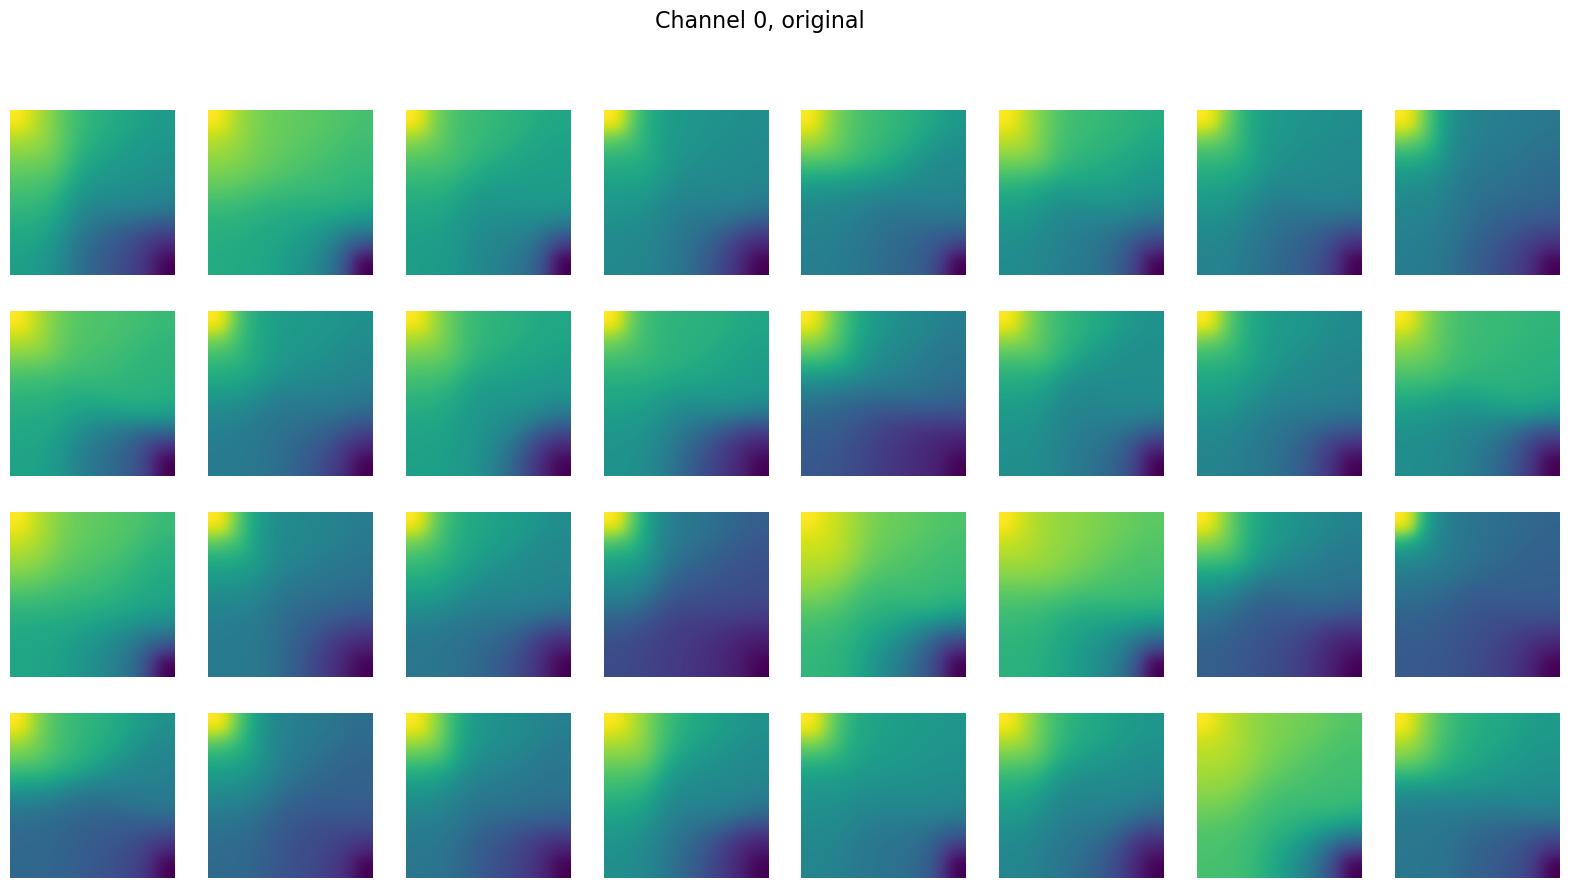

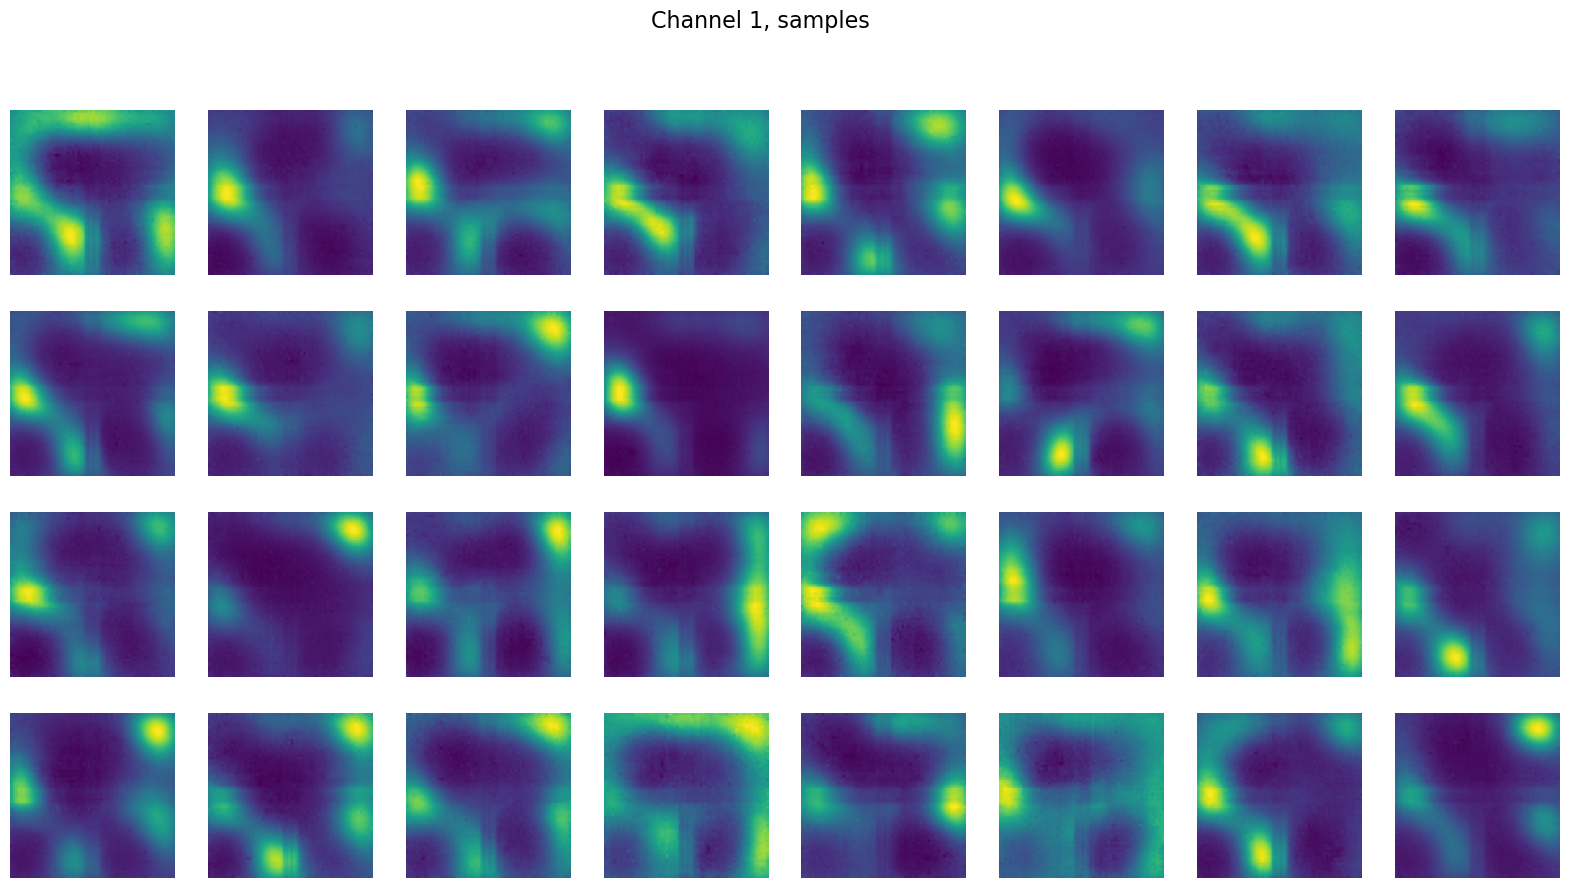

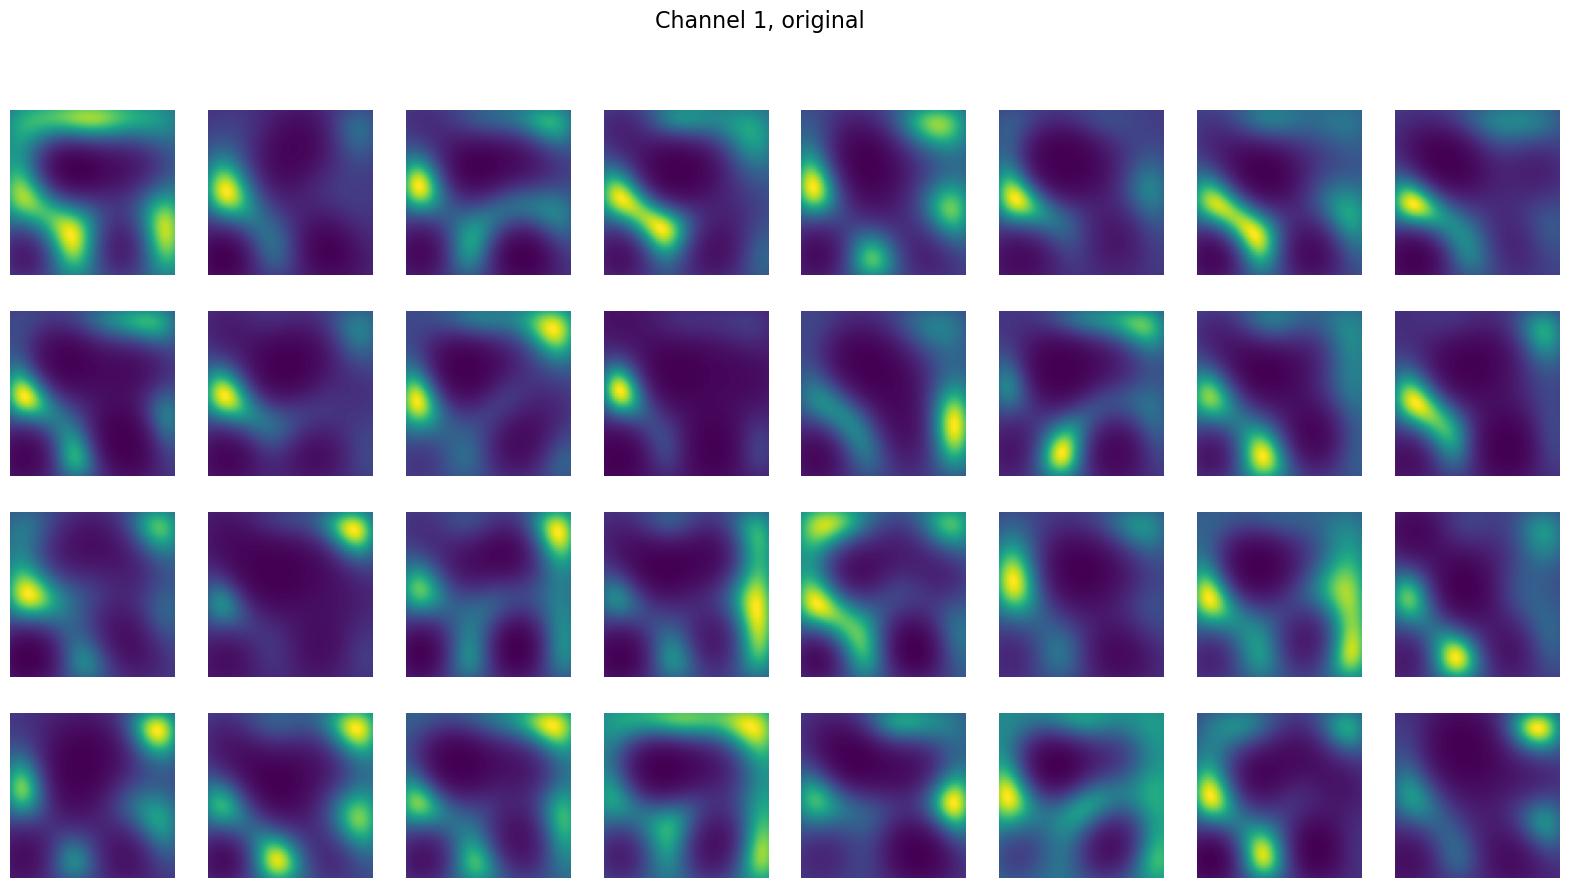

In [16]:
def plot_channel(samples, channel, title):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flatten()):
        if i < samples.shape[0]:
            ax.imshow(samples[i, channel, :, :])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty plots

plot_channel(samples, 0, 'Channel 0, samples')
plot_channel(x, 0, 'Channel 0, original')
plot_channel(samples, 1, 'Channel 1, samples')
plot_channel(x, 1, 'Channel 1, original')
plt.show()

In [7]:
samples = edm_sampler(model, latents=latents, class_labels=c, randn_like=rnd.randn_like)

torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])
torch.Size([32, 512]) torch.Size([32, 512])


KeyboardInterrupt: 